In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pickle




In [3]:
def OLS(X,y,single=False):
    n,d=X.shape
    inv_m=np.linalg.inv(X.T@X+0.01*np.identity(d))
    
    ols_vec=inv_m@X.T@y    ## (d,1) vector
    if single:
        std=sigma*inv_m[0,0]**0.5
        return ols_vec[0,0],std
    
        
    return ols_vec


def gen_data(n,d,theta_star):         ## generate (X,y),   theta_star d times 1
     
    p=rand_prob   ## the prob. of following ols
    
    
    
    X=np.zeros((n,d))
    y=np.zeros((n,1))
    
    eps=np.random.normal(loc=0,scale=sigma,size=(n,))
    
    #eps=(np.random.binomial(n=1,p=0.5,size=(n,))-0.5)*sigma/0.5


    
    indicator=np.random.binomial(1,p,size=(n,))
    
    
    
    
    X[:,1:]=np.random.normal(loc=0.,scale=1,size=(n,d-1))
    X[0,0]=1.
    y[0,0]=X[0:1,:]@theta_star+eps[0]
    
    for i in range(1,n):
        X_sub=X[:i,:]
        y_sub=y[:i,:]
        theta_ols= OLS(X_sub,y_sub)
        
       
        
        index=(np.sign(theta_ols[0,0])+1)/2
        
        X[i,0]=indicator[i]*index+ (1-indicator[i])*(1-index)
        
        y[i,0]=X[i:(i+1),:]@theta_star+eps[i]

        
    return X,y




def tale_est(X,y):    ##TALE estimator,    X,y are both 2-d array
    
    
    def f(x):
        value=np.exp(2)*x
        return 1/np.sqrt(x*np.log(value) *(np.log(np.log(value)))**2)
    
    
    n,d=X.shape
    
    s_all=np.cumsum(X[:,0]**2)
    s0=np.log(np.log(n))
    s_all=s_all+s0
    
    w_all=f(s_all/s0)*X[:,0]/s0**0.5
    w_all=w_all.reshape(-1,1)
    
    
   
    
    theta_prior=OLS(X,y)
    
    value_1= np.sum(w_all*(y-X[:,1:]@theta_prior[1:,:]),axis=0)
    
   
    
    value_2=np.sum(w_all*X[:,0:1],axis=0)
    hat_theta=value_1/value_2
    
    return hat_theta[0],sigma*np.linalg.norm(w_all)/value_2    ##tale, ols



def W_corr(X,y,lam,single=False):        ##W-decorrelation 
    n,d=X.shape
    theta_ols=OLS(X,y)
    eigvals, _ = np.linalg.eigh(X.T@X)

    #lam=eigvals[0]/np.log(n)
    #print(lam,'lam')
    #lam=20
    
    var_m=np.zeros((d,d))
    
    
    
    WX=np.zeros((d,d))
    theta_w=np.copy(theta_ols)
   
    for i in range(n):
        w=(np.identity(d)-WX)@(X[i:(i+1),:].T)/(lam+np.linalg.norm(X[i:(i+1),:])**2)
        WX=np.copy(WX+w@X[i:(i+1),:])
        
        theta_w=theta_w+ w* (y[i:(i+1),:]-X[i:(i+1),:]@theta_ols)
        
        var_m=var_m+w@w.T
    
    if single:
        return theta_w[0,0], sigma*var_m[0,0]**0.5
    
    return theta_w
    
    
    





In [4]:
## problem parameters 



n=500
d=50
rep=1000
sigma=0.3 ## scale of the zero mean noise
alpha_list=np.linspace(0.7,0.95,20)
rand_prob=0.8 ##probability of following ols

record_tale=np.zeros((rep,2))

record_w=np.zeros((rep,2))

record_ols=np.zeros((rep,2))

record_mineig=np.zeros(rep)




theta_star=np.ones((d,1))
theta_star[0,0]=0
theta_star=theta_star/np.linalg.norm(theta_star)

In [5]:
seed=19          


np.random.seed(seed)
        



for j in range(rep):
  
 
    X,y=gen_data(n,d,theta_star)

    record_tale[j,0],record_tale[j,1]= tale_est(X,y)
    record_tale[j,0]=np.copy(record_tale[j,0])-theta_star[0,0]
    

    record_ols[j,0],record_ols[j,1]= OLS(X,y,single=True)
    record_ols[j,0]=np.copy(record_ols[j,0])-theta_star[0,0]
    
    eigvals, _ = np.linalg.eigh(X.T@X)
    record_mineig[j]=eigvals[0]
    

    
    
lam=np.quantile(record_mineig, 1/n)/(np.log(n))           ##choose the tuning parameter in W_decorrelation
np.random.seed(seed)
#print(lam)
    
for j in range(rep):                                      ## run w-decorrelation
    
   
    X,y=gen_data(n,d,theta_star)
        
    record_w[j,0],record_w[j,1]= W_corr(X,y,lam,single=True)
    record_w[j,0]=np.copy(record_w[j,0])-theta_star[0,0]
    

    
    
        
print('done')


    
record_list=[record_tale,record_w,record_ols]    

with open("./fig/n_{}_d_{}_{}.pkl".format(n,d,'inference'), "wb") as file:
    pickle.dump([(seed,n,d,rep,sigma,theta_star,rand_prob),record_list], file)





    

KeyboardInterrupt: 

In [6]:
## functions for plotting the figures



def quantile_freqs(record, alphas, ci_type,plot_width=False,plot_concen=False):
    # Normalize x to a standard Gaussian
    
    def concen_fun(n,d,record,alpha,ci_type):  
        
        def concen_value(n,d,alpha):    ##coverage with probability alpha
            c=1   ## should be able to show from end of optimism paper than c\geq 2
            delta=1-alpha
            v1=2*(1+1/np.log(n))*np.log(1/delta)+c*d*np.log(d*np.log(n))
            return v1**0.5
        
        if ci_type=='mid':
            high_prob_ci=concen_value(n,d,alpha)*record[:,1]
            freq=np.mean(np.abs(record[:,0])<high_prob_ci)
            wid=np.mean(2*high_prob_ci)
            wid_std=np.std(2*high_prob_ci)
            return freq,wid,wid_std
        
        elif ci_type=='up':
            high_prob_ci=concen_value(n,d,2*alpha-1)*record[:,1]
            freq=np.mean(record[:,0]>-high_prob_ci)
        elif ci_type=='down':
            high_prob_ci=concen_value(n,d,2*alpha-1)*record[:,1]
            freq=np.mean(record[:,0]<high_prob_ci)
            
        return freq
    
 
    
    
    
    
    
    
    
    
    
    if plot_width:
        ci_type='mid'
        
    
    
    
    
    scale_record =record[:,0]/record[:,1]
    

    # Define the quantile ranges based on the specified confidence interval type
    if ci_type == "up":
        quantiles = [(norm.ppf(1-alpha), np.inf) for alpha in alphas]
    elif ci_type == "mid":
        quantiles = [(norm.ppf(0.5-0.5*alpha), norm.ppf(0.5+0.5*alpha)) for alpha in alphas]
    elif ci_type == "down":
        quantiles = [(-np.inf, norm.ppf(alpha)) for alpha in alphas]
    elif ci_type == "hist":
        
        return scale_record
        
    
    else:
        raise ValueError("ci_type must be 'up', 'mid', 'down','hist'")


    # Initialize an empty array to hold the frequency results
    freqs = np.zeros(len(alphas))
    wids = np.zeros(len(alphas))
    wids_std=np.zeros(len(alphas))



    # For each pair of quantiles, calculate the frequency of x in that range
    for i, (q_low, q_high) in enumerate(quantiles):
        
        if plot_concen:
            if ci_type=='mid':
                freqs[i],wids[i],wids_std[i]=concen_fun(n,d,record,alphas[i],ci_type)
            else:
                freqs[i]=concen_fun(n,d,record,alphas[i],ci_type)
            continue
                
        
        
        
        
        
        
        
        
        tf_index=(scale_record >= q_low) & (scale_record <= q_high)
        freqs[i] = (tf_index).mean()
        
            
            
        if ci_type=='mid':
            width=record[:,1]*(norm.ppf((1+alphas[i])/2) -norm.ppf((1-alphas[i])/2))
            wids[i]=np.mean(width)
            wids_std[i]=np.std(width)
            
            
            
            
    
    if ci_type=='mid' and plot_width:
        return freqs,wids,wids_std


            

    return freqs









def plot_all(n,d,alphas,ci_type):
    with open("./fig/n_{}_d_{}_{}.pkl".format(n,d,'inference'), "rb") as file:
        (seed,n,d,rep,sigma,theta_star,rand_prob),record_list=pickle.load(file)
    
    
    if ci_type=='width':
        ci_type='mid'
        plot_width=True
    else:
        plot_width=False
    
    
    
    
    
    plt.figure(figsize=(8,6))
    plt.rcParams.update({'font.size': 25})
    
    color_ols = 'navy'
    color_tale = 'darkorange'
    color_pdf = 'firebrick'
    color_baseline = 'firebrick'
    color_concen='dodgerblue'
    color_w='forestgreen'




    
    title_fontsize = 23
    label_fontsize = 21
    capsize=3
    hist_alpha=0.5
    linewidth=3
    markersize=10



    ''' color options
        'navy'
        'darkorange'
        'forestgreen'
        'darkviolet'
        'firebrick'
        'dodgerblue'
    '''
    
    

    
    record_tale,record_w,record_ols=record_list
    
    
    freqs_ols=quantile_freqs(record_ols, alphas, ci_type,plot_width)
    
    freqs_tale=quantile_freqs(record_tale, alphas, ci_type,plot_width)
    
    freqs_w=quantile_freqs(record_w, alphas, ci_type,plot_width)
    
    freqs_concen=quantile_freqs(record_ols, alphas, ci_type,plot_width,plot_concen=True)

  
    
    
    if plot_width:
        
        freqs_ols,wid_mean_ols,wid_std_ols=freqs_ols
        
        freqs_w,wid_mean_w,wid_std_w=freqs_w


        freqs_tale,wid_mean_tale,wid_std_tale=freqs_tale
        
        freqs_concen,wid_mean_concen,wid_std_concen=freqs_concen


        
        
       
    

    
    
        # Plot the OLS and TALE with error bars
        
        
        plt.errorbar(alphas, wid_mean_tale, yerr=wid_std_tale,linestyle='--', marker='^', label='TALE', \
                             color=color_tale, capsize=capsize,markersize=markersize,linewidth=linewidth)
        
        plt.errorbar(alphas, wid_mean_ols, yerr=wid_std_ols, linestyle='-', marker='o', label='OLS',\
                             color=color_ols, capsize=capsize,markersize=markersize,linewidth=linewidth)
        
        plt.errorbar(alphas, wid_mean_w, yerr=wid_std_w,linestyle=':', marker='v', label='W-decorr', \
                             color=color_w, capsize=capsize,markersize=markersize,linewidth=linewidth)
        
        
        #plt.errorbar(alphas, wid_mean_concen, yerr=wid_std_concen,linestyle='-.', marker='s', label='Concen', \
        #                    color=color_concen, capsize=capsize,linewidth=linewidth)

        # Increase font size for the title and labels
    

        plt.title('Width of two-sided CI for '+r'$\theta^*_1$', fontsize=title_fontsize)
        plt.ylabel('Width of CIs', fontsize=label_fontsize)
        plt.xlabel('Target coverage probability '+r'$(1-\alpha)$', fontsize=label_fontsize)

        # Show grid
        plt.grid(True)

        # Show legend
        plt.legend(fontsize=label_fontsize)

        # Use tight layout
        #plt.tight_layout()

        # Save the figure before showing it
        plt.savefig('./fig/n_{}_d_{}_type_{}_{}.pdf'.format(n,d,ci_type,'inference'), format='pdf', bbox_inches='tight')

        # Show the plot
        plt.show()
        
       
        return
    
    
    
    elif ci_type=='hist':
        
        scale_record_ols=freqs_ols
        scale_record_tale=freqs_tale
        #scale_record_w=freqs_w


        
        
        

        
      

        # Plot the histograms
        plt.hist(scale_record_tale, bins=20, density=True, label='TALE', color=color_tale, \
                       alpha=hist_alpha,linewidth=linewidth)
        
        plt.hist(scale_record_ols, bins=20, density=True, label='OLS', color=color_ols,\
                       alpha=hist_alpha,linewidth=linewidth)
        
        #plt.hist(scale_record_w, bins=20, density=True, label='W-decorrelation', color=color_w, \
                       #alpha=hist_alpha,linewidth=linewidth)
   


        xmin, xmax = plt.xlim()

        x_pdf = np.linspace(-4,4, 100)
        plt.xlim(-4,4)
        plt.ylim(0,0.67)

        y_pdf = norm.pdf(x_pdf, 0, 1)

        plt.plot(x_pdf, y_pdf, color=color_pdf, linewidth=linewidth)

        # Set the title and labels with appropriate font sizes
      

        plt.title('Histogram of the scaled errors for '+r'$\theta^*_1$', fontsize=title_fontsize)
        plt.xlabel(r'${(\widehat\theta_{1}-\theta^*_{1})}/{\sqrt{\mathrm{\widehat{Var}}(\widehat\theta_{1})}}}$', fontsize=label_fontsize)
        plt.ylabel('Density', fontsize=label_fontsize)

        # Show grid
        plt.grid(True)

        # Show legend
        plt.legend(fontsize=label_fontsize)

        # Use tight layout
        #plt.tight_layout()

        # Save the figure before showing it
        plt.savefig('./fig/n_{}_d_{}_type_{}_{}.pdf'.format(n,d,ci_type,'inference'), format='pdf', bbox_inches='tight')

        # Show the plot
        plt.show()


            
        return
        



        
    
    
    
    
    # Calculate the standard deviation of a Bernoulli distribution for the error bars
    errors_ols = np.sqrt(freqs_ols * (1 -freqs_ols)/rep)
    
    errors_tale = np.sqrt(freqs_tale * (1 -freqs_tale)/rep)
    
    errors_w = np.sqrt(freqs_w * (1 -freqs_w)/rep)

    errors_concen = np.sqrt(freqs_concen * (1 -freqs_concen)/rep)



    
    
    
    


    plt.plot(alpha_list, alpha_list, label='Baseline', color=color_baseline,linewidth=linewidth)
    
    
    plt.errorbar(alphas, freqs_tale, yerr=errors_tale, linestyle='--', marker='^', label='TALE',\
                         color=color_tale, capsize=capsize,markersize=markersize,linewidth=linewidth)
    
    plt.errorbar(alphas, freqs_ols, yerr=errors_ols, linestyle='-', marker='o', label='OLS',\
                        color=color_ols, capsize=capsize,markersize=markersize,linewidth=linewidth)
    
    plt.errorbar(alphas, freqs_w, yerr=errors_w, linestyle=':', marker='v', label='W-decorr',\
                        color=color_w, capsize=capsize,markersize=markersize,linewidth=linewidth)
  


    
    plt.errorbar(alphas, freqs_concen, yerr=errors_concen, linestyle='-.', marker='s', label='Concen',\
                         color=color_concen, capsize=capsize,markersize=markersize,linewidth=linewidth)


    if ci_type=='up':
        plt.title('Upper tail coverage for '+r'$\theta^*_1$',fontsize=title_fontsize)
    elif ci_type=='down':
        plt.title('Lower tail coverage for '+r'$\theta^*_1$',fontsize=title_fontsize)
    elif ci_type=='mid':
        plt.title('Two-sided coverage for '+r'$\theta^*_1$',fontsize=title_fontsize)
        
        
        
    plt.ylabel('Empirical coverage probability',fontsize=label_fontsize)
    plt.xlabel('Target coverage probability '+r'$(1-\alpha)$',fontsize=label_fontsize)
    plt.grid(True)
    plt.legend(fontsize=label_fontsize)

    # Show the plot
    
    plt.savefig('./fig/n_{}_d_{}_type_{}.pdf'.format(n,d,ci_type), format='pdf', bbox_inches='tight')
    plt.show()
    
    
    

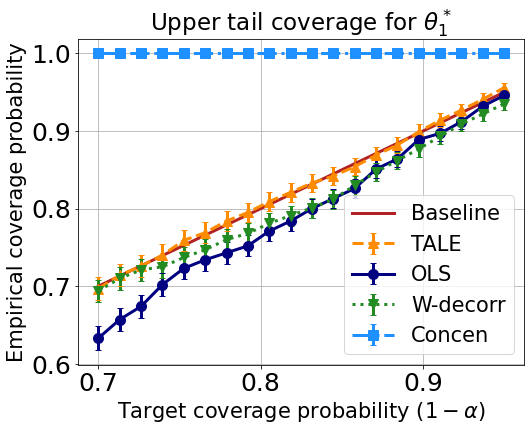

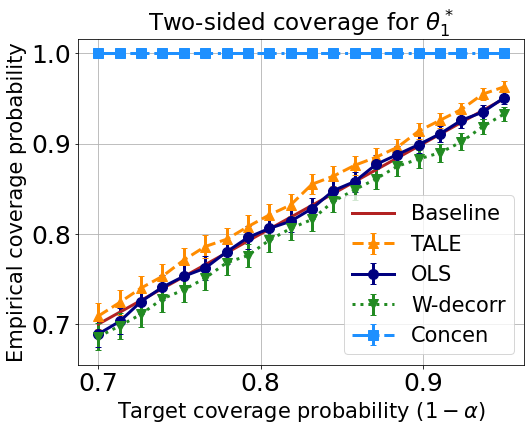

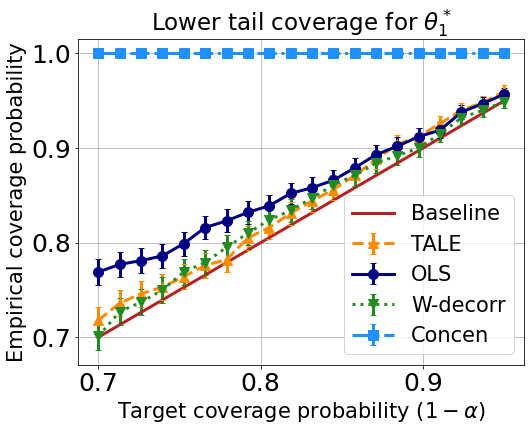

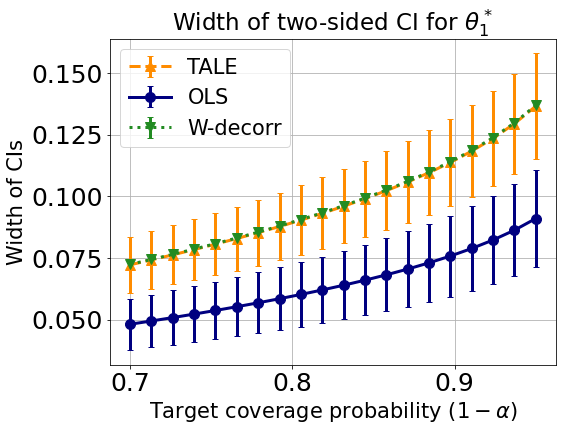

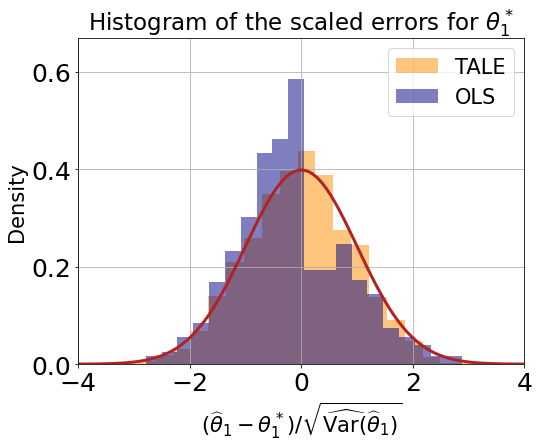

In [7]:
##plot the figures




for ci_type in ['up','mid','down','width','hist']:

    plot_all(n,d,alpha_list,ci_type)




